In [1]:
import numpy as np
import glob2
import matplotlib.pyplot as plt
import os
import json
import itertools
import pandas as pd
import seaborn as sns

In [2]:
# Four params and their values, each is a np array
queen_bee_concentrations = [0.15]
print("Q = {}".format(queen_bee_concentrations))

worker_bee_concentrations = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
print("W = {}".format(worker_bee_concentrations))

diffusion_coefficients = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
print("D = {}".format(diffusion_coefficients))

worker_bee_thresholds = [0.005, 0.5]
print("T = {}".format(worker_bee_thresholds))


Q = [0.15]
W = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
D = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
T = [0.005, 0.5]


In [3]:
# Get names of all 64 json's
json_list = list(map(lambda x : x.split("/")[-1], glob2.glob("avg_distance_data/*.json")))

In [4]:
def get_matching_filenames(json_list, param_1, param_2, value_1, value_2):
    matching_json_names = []
    for i in range(len(json_list)):
        if (json_list[i].find(param_1+str(value_1)) != -1) and (json_list[i].find(param_2+str(value_2)) != -1):
            matching_json_names.append(json_list[i])
    
    return matching_json_names

In [5]:
# # Test above function on 1 set of param pair values
# names = get_matching_filenames(json_list, "Q", "W", 0.01, 0.005)
# print(names)

In [6]:
def get_ending_distances(json_file):
    # Get the 10 ending values of a single json
    with open("avg_distance_data/" + json_file, "r") as f:
        data = json.load(f)
        # print(data)
        
    # For 1 JSON of 10 replicate swarms: going through its 10 lists
    dist_list = []
    for i in range(len(data)):
        ending_dist = data[i][-1]
        dist_list.append(ending_dist)
        
    dist_avg = np.median(dist_list)
    dist_var = np.var(dist_list)
    
    return dist_avg, dist_var

In [8]:
# Testing above function
x = get_ending_distances("Q0.15_W0.1_D0.1_T0.5_wb3.json")
print(x)

(0.07914835067243417, 0.03221073233807765)


In [9]:
def get_mean_var(json_list, param_1, param_2, value_1, value_2):

    # Load in a json list and get ending value of each list, then average and variance those 160 values
    
    # param_pair_distances = []
    # print(len(param_pair_distances))
    # print(param_pair_distances[0])

    averages = []
    variances = []
    
    names = get_matching_filenames(json_list, param_1, param_2, value_1, value_2)

    for n in names:
        # print(n)
        distance_tuple = get_ending_distances(n)
        # print(distance_tuple)
        averages.append(distance_tuple[0])
        variances.append(distance_tuple[1])

#     # Merge lists in param_pair_distances
#     merged = list(itertools.chain.from_iterable(param_pair_distances))
#     # print(merged)
#     merged_mean = np.mean(merged)
#     # print(merged_mean)
#     merged_var = np.var(merged)
#     # print(merged_var)
    
#     return merged_mean, merged_var
    return np.median(averages), np.median(variances)


In [10]:
# Test above function
get_mean_var(json_list, "W", "D", 0.0005, 0.5)

(0.058323946097636914, 1.50218567376738e-05)

In [11]:
# Test above function
get_mean_var(json_list, "W", "T", 0.01, 0.005)

(0.05886192635617797, 2.279001352327634e-05)

In [12]:
# Iterate through different pairs of params and their values

def compare_params(json_list, param_1, param_2, list_1, value_2):
    # Create one column for a W values against 4 queen values
    all_averages = []
    all_variances = []
    for item in list_1:
        # print(item)
        mean_var = get_mean_var(json_list, param_1, param_2, item, value_2)
        # print(mean_var)
        all_averages.append(mean_var[0])
        all_variances.append(mean_var[1]) 
        
    return all_averages, all_variances

In [13]:
# Test
compare_params(json_list, "W", "D", worker_bee_concentrations, 0.05)
# test_variances = compare_params(json_list, "Q", "W", queen_bee_concentrations, 0.005)
# test_means

([1.1596981783709976,
  1.1534456913915432,
  1.1465451161782563,
  1.1695521684626464,
  1.1573745672355316,
  1.1297177494068658,
  0.06073428254240691],
 [0.009191629414820159,
  0.0029339032043601996,
  0.007866773589555719,
  0.010293305122506731,
  0.017979548703649265,
  0.0965144989414807,
  0.0014657060813114274])

## Returning DF 

In [14]:
def get_dataframe(json_list, param_1, list_1, param_2, list_2, avg_or_var, index_array):
    
    # Get 4 lists of values contained in cumulative list
    vals_list = []
    for val in list_2:
        if avg_or_var == "avg":
            x = compare_params(json_list, param_1, param_2, list_1, val)[0]
            vals_list.append(x)
        elif avg_or_var == "var":
            x = compare_params(json_list, param_1, param_2, list_1, val)[1]
            vals_list.append(x)
        
    # Turn into dict
    data = {}
    for i, key in enumerate(list_2):
        if len(str(key)) > 7:
            key = "{0:.5f}".format(key)
            # print(key, type(key))
            data[key] = vals_list[i]
        else:
            # print(key, type(key))
            data[key] = vals_list[i]
            
    # Truncate labels in index_array
    new_index_array = []
    for j, label in enumerate(index_array):
        if len(str(label)) > 7:
            new_index_array.append("{0:.4f}".format(label))
        else:
            new_index_array.append(label)
        
            
    # Turn into dataframe 
    df = pd.DataFrame(data, index=[new_index_array])

    return df


### Queen vs Worker

In [15]:
# Q_W_avg_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "W", worker_bee_concentrations, "avg", [0.01, 0.173, 0.34, 0.5])
# print("Q_W_avg_df:")
# print(Q_W_avg_df)
# print("\n")

# Q_W_var_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "W", worker_bee_concentrations, "var", [0.01, 0.173, 0.34, 0.5])
# print("Q_W_var_df:")
# print(Q_W_var_df)
# print("\n")

### Queen vs Coefficient

In [16]:
# Q_D_avg_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "D", diffusion_coefficients, "avg", [0.01, 0.173, 0.34, 0.5])
# print("Q_D_avg_df:")
# print(Q_D_avg_df)
# print("\n")

# Q_D_var_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "D", diffusion_coefficients, "var", [0.01, 0.173, 0.34, 0.5])
# print("Q_D_var_df:")
# print(Q_D_var_df)
# print("\n")

### Queen vs Threshold

In [17]:
# Q_T_avg_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "T", worker_bee_thresholds, "avg", [0.01, 0.173, 0.34, 0.5])
# print("Q_T_avg_df:")
# print(Q_T_avg_df)
# print("\n")

# Q_T_var_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "T", worker_bee_thresholds, "var", [0.01, 0.173, 0.34, 0.5])
# print("Q_T_var_df:")
# print(Q_T_var_df)
# print("\n")

### Worker vs Coefficient

In [18]:
# W_D_avg_df = get_dataframe(json_list, "W", worker_bee_concentrations, "D", diffusion_coefficients, "avg", worker_bee_concentrations)
# print("W_D_avg_df:")
# print(W_D_avg_df)
# print("\n")

# W_D_var_df = get_dataframe(json_list, "W", worker_bee_concentrations, "D", diffusion_coefficients, "var", worker_bee_concentrations)
# print("W_D_var_df:")
# print(W_D_var_df)
# print("\n")

### Worker vs Threshold

In [19]:
# W_T_avg_df = get_dataframe(json_list, "W", worker_bee_concentrations, "T", worker_bee_thresholds, "avg", worker_bee_concentrations)
# print("W_T_avg_df:")
# print(W_T_avg_df)
# print("\n")

# W_T_var_df = get_dataframe(json_list, "W", worker_bee_concentrations, "T", worker_bee_thresholds, "var", worker_bee_concentrations)
# print("W_T_var_df:")
# print(W_T_var_df)
# print("\n")

### Coefficient vs Threshold

In [20]:
# D_T_avg_df = get_dataframe(json_list, "D", diffusion_coefficients, "T", worker_bee_thresholds, "avg", diffusion_coefficients)
# print("D_T_avg_df:")
# print(D_T_avg_df)
# print("\n")

# D_T_var_df = get_dataframe(json_list, "D", diffusion_coefficients, "T", worker_bee_thresholds, "var", diffusion_coefficients)
# print("D_T_var_df:")
# print(D_T_var_df)
# print("\n")

## Plotting heatmap from dataframe for a pair of params

In [21]:
def plot_heatmap(df_avg, df_var, x_label, y_label, filename, t_value):
    
    sns.set(font_scale = 1.5)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(15,4))
    
    sns.heatmap(df_avg, cmap="Greens", cbar_kws={'label': ''}, ax=ax1, vmin=0, vmax=4)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_title('Average distance from queen')
    
    sns.heatmap(df_var, cmap="Blues", cbar_kws={'label': ''}, ax=ax2, vmin=0, vmax=2)
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)
    ax2.set_title('Variance distance from queen')

    ax1.invert_yaxis()
    ax2.invert_yaxis()
    
    # ax1.set_xticks(x_ticks)

    fig.text(0.5, 1.0, "Worker activation threshold = {}".format(t_value), ha='center', va='center')
    # fig.text(-0.02, -0.1, y_label, ha='center', va='center')
    
    
    plt.subplots_adjust(top=0.88)
    
    plt.savefig('/Users/dieumynguyen/Desktop/Projects/bee_communication/figures/param_heatmap/{}.pdf'.format(filename), bbox_inches='tight')
    

## Re-plotting with 3 free parameters while Q is fixed

In [22]:
worker_bee_thresholds

[0.005, 0.5]

In [23]:
# Get names of all json's for a single T value - do this 4 times - each T has 16 files

jsons_T_1 = list(map(lambda x : x.split("/")[-1], glob2.glob("avg_distance_data/*T{}*.json".format(worker_bee_thresholds[0]))))
jsons_T_2 = list(map(lambda x : x.split("/")[-1], glob2.glob("avg_distance_data/*T{}*.json".format(worker_bee_thresholds[1]))))
# jsons_T_3 = list(map(lambda x : x.split("/")[-1], glob2.glob("avg_distance_data/*T{}*.json".format(worker_bee_thresholds[2]))))
# jsons_T_4 = list(map(lambda x : x.split("/")[-1], glob2.glob("avg_distance_data/*T{}*.json".format(worker_bee_thresholds[3]))))


In [24]:
# print(len(jsons_T_2))
# jsons_T_2

### T = 0.005 heatmaps for W vs D

In [25]:
W_D_avg_df_2 = get_dataframe(jsons_T_1, "W", worker_bee_concentrations, "D", diffusion_coefficients, "avg", worker_bee_concentrations)
print("W_D_avg_df:")
print(W_D_avg_df_2)
print("\n")

W_D_var_df_2 = get_dataframe(jsons_T_1, "W", worker_bee_concentrations, "D", diffusion_coefficients, "var", worker_bee_concentrations)
print("W_D_var_df:")
print(W_D_var_df_2)
print("\n")

W_D_avg_df:
           0.005     0.010     0.050     0.100     0.500     1.000
0.0005  2.258535  2.300566  0.060554  0.058133  0.057388  0.056918
0.0010  2.306483  2.335819  0.064118  0.057408  0.059196  0.055827
0.0050  1.845194  0.120863  0.058179  0.056860  0.056276  0.055872
0.0100  1.825894  0.073032  0.058283  0.057499  0.056476  0.059441
0.0500  0.084146  0.067400  0.059831  0.058113  0.057501  0.058164
0.1000  0.076976  0.066073  0.059373  0.058392  0.055271  0.056501
0.5000  0.083405  0.061556  0.057190  0.057708  0.056058  0.060964


W_D_var_df:
           0.005     0.010     0.050     0.100     0.500     1.000
0.0005  0.021148  0.036880  0.000026  0.000015  0.000015  0.000016
0.0010  0.035838  0.103965  0.000020  0.000010  0.000016  0.000018
0.0050  0.305123  0.780878  0.000017  0.000020  0.000016  0.000012
0.0100  0.664111  0.157164  0.000006  0.000009  0.000022  0.000023
0.0500  0.898958  0.002681  0.000012  0.000008  0.000027  0.000013
0.1000  0.344357  0.000063  0.000008

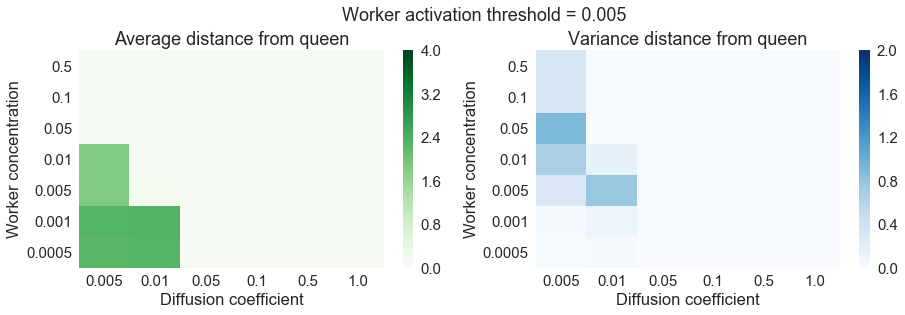

In [26]:
plot_heatmap(W_D_avg_df_2, W_D_var_df_2, 'Diffusion coefficient', 'Worker concentration', 
             "Threshold0.005_Worker_Coefficient", 0.005)


### T = 0.5 heatmaps for W vs D

In [27]:
W_D_avg_df_5 = get_dataframe(jsons_T_2, "W", worker_bee_concentrations, "D", diffusion_coefficients, "avg", worker_bee_concentrations)
print("W_D_avg_df:")
print(W_D_avg_df_5)
print("\n")

W_D_var_df_5 = get_dataframe(jsons_T_2, "W", worker_bee_concentrations, "D", diffusion_coefficients, "var", worker_bee_concentrations)
print("W_D_var_df:")
print(W_D_var_df_5)
print("\n")

W_D_avg_df:
           0.005     0.010     0.050     0.100     0.500     1.000
0.0005  2.367280  2.325344  2.258842  2.256263  0.059260  0.056501
0.0010  2.275097  2.321435  2.242774  2.281444  0.054265  0.055302
0.0050  2.337681  2.350750  2.234911  2.312960  0.057338  0.057705
0.0100  2.376882  2.332414  2.280821  2.342627  0.057844  0.057247
0.0500  2.264317  2.285741  2.254918  2.248183  0.060531  0.055693
0.1000  2.357936  2.277034  2.200062  0.079148  0.059364  0.059466
0.5000  2.389268  2.128069  0.064279  0.058154  0.057433  0.058113


W_D_var_df:
           0.005     0.010     0.050     0.100     0.500     1.000
0.0005  0.020934  0.031493  0.018357  0.296889  0.000015  0.000018
0.0010  0.016513  0.033217  0.005848  0.103490  0.000019  0.000012
0.0050  0.030816  0.026176  0.015717  0.228528  0.000012  0.000010
0.0100  0.018309  0.018067  0.020580  0.252567  0.000018  0.000018
0.0500  0.015592  0.012354  0.035947  0.377086  0.000024  0.000018
0.1000  0.027589  0.033687  0.193021

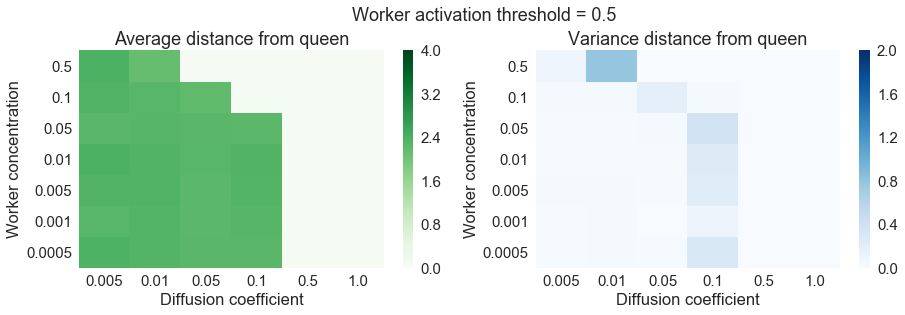

In [28]:
plot_heatmap(W_D_avg_df_5, W_D_var_df_5, 'Diffusion coefficient', 'Worker concentration', 
             "Threshold0.5_Worker_Coefficient", 0.5)
